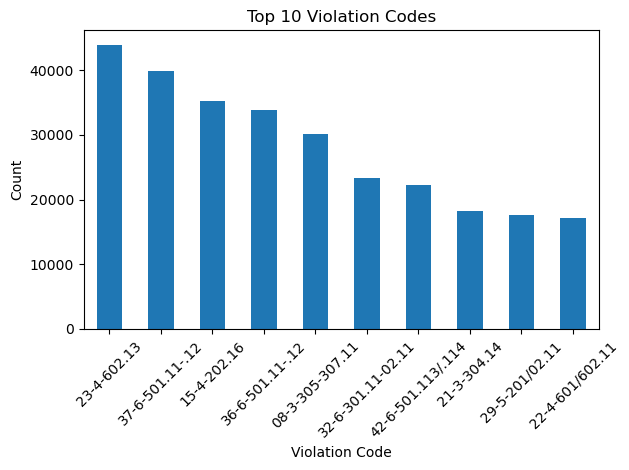

In [22]:
import sqlite3, pandas as pd, matplotlib.pyplot as plt

conn = sqlite3.connect("../boston.db")

df_codes = pd.read_sql("""
    SELECT violation_code, COUNT(*) AS cnt
    FROM violations
    WHERE violation_code IS NOT NULL
    GROUP BY violation_code
    ORDER BY cnt DESC
    LIMIT 10
""", conn)

df_codes.plot(kind="bar", x="violation_code", y="cnt", legend=False, rot=45)
plt.title("Top 10 Violation Codes")
plt.xlabel("Violation Code")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Search Recent Violations by Business Name

This function allows you to search for the most recent violations for any business.


In [23]:
def get_recent_violations(business_name, limit=10, show_details=True):
    """
    Search for recent violations by business name (case-insensitive, partial match)
    Uses JOIN with violation_codes table for normalized data access
    
    Args:
        business_name: Name or partial name of the business to search
        limit: Maximum number of results to return (default: 10)
        show_details: If True, prints detailed formatted output (default: True)
    
    Returns:
        DataFrame with the most recent violations for that business
    """
    query = """
        SELECT 
            v.business_name,
            v.address,
            v.violation_code,
            COALESCE(vc.description, v.violation_desc, 'No description available') as violation_description,
            v.date,
            v.status
        FROM violations v
        LEFT JOIN violation_codes vc ON v.violation_code = vc.code
        WHERE v.business_name LIKE ?
        ORDER BY v.date DESC
        LIMIT ?
    """
    
    # Add wildcards for partial matching
    search_pattern = f"%{business_name}%"
    
    df = pd.read_sql(query, conn, params=(search_pattern, limit))
    
    if len(df) == 0:
        print(f"No violations found for business name containing: '{business_name}'")
        print("\nTip: Try a shorter or partial name (e.g., 'Pizza' instead of 'Joe's Pizza Shop')")
        return df
    
    print(f"Found {len(df)} recent violation(s) for businesses matching '{business_name}'")
    
    # Display detailed formatted output if requested
    if show_details:
        print("\n" + "="*70)
        for idx, row in df.iterrows():
            print(f"\n📍 {row['business_name']}")
            print(f"   Address: {row['address']}")
            print(f"   Date: {row['date']}")
            print(f"   Code: {row['violation_code'] if pd.notna(row['violation_code']) else 'N/A'}")
            print(f"   Violation: {row['violation_description']}")
            print(f"   Status: {row['status'] if pd.notna(row['status']) else 'N/A'}")
        print("\n" + "="*70)
    
    return df


### Example Usage

Search for businesses and see **full violation descriptions** from the normalized database!

The search now uses JOINs with the `violation_codes` table to show proper descriptions for each violation code.


In [24]:
# Example 1: Search with detailed formatted output (shows violation descriptions!)
violations = get_recent_violations("Dunkin", limit=3)

# To get just the dataframe without formatted output:
# violations = get_recent_violations("Dunkin", limit=3, show_details=False)


Found 3 recent violation(s) for businesses matching 'Dunkin'


📍 DUNKIN'
   Address: 157  SEAPORT BL
   Date: 2025-10-07
   Code: 590.005/5-205.15-P
   Violation: System Maintained in Good Repair (P)
   Status: HE_Fail

📍 DUNKIN'
   Address: 157  SEAPORT BL
   Date: 2025-10-07
   Code: 590.006/6-501.11-C
   Violation: Repairing-Premises  Structures  Attachments  and Fixtures-Methods (C)
   Status: HE_Fail

📍 DUNKIN'
   Address: 157  SEAPORT BL
   Date: 2025-10-07
   Code: 590.006/6-501.18-C
   Violation: Cleaning of Plumbing Fixtures (C)
   Status: HE_Fail



In [31]:
# Example 2: View as DataFrame (without formatted output)
starbucks_violations = get_recent_violations("Taco Bell", limit=5, show_details=False)
starbucks_violations


Found 5 recent violation(s) for businesses matching 'Taco Bell'


,business_name,address,violation_code,violation_description,date,status
0,Taco Bell,74 SUMMER ST,590.006/6-501.14-C,Cleaning Ventilation Systems Nuisance and Dis...,2025-09-23,HE_Filed
1,Taco Bell,2 MAVERICK SQ,590.004/4-301.11-PF,Cooling Heating and Holding Capacities-Equip...,2025-09-08,HE_Pass
2,Taco Bell,2 MAVERICK SQ,590.004/4-301.11-PF,Cooling Heating and Holding Capacities-Equip...,2025-08-25,HE_Fail
3,Taco Bell,449 W BROADWAY,590.003/3-302.12-C,Food Storage Containers Identified with Common...,2025-06-23,HE_Filed
4,Taco Bell No. 29265,1560 VFW PW,590.004/4-202.16-C,Nonfood-Contact Surfaces (C),2025-06-20,HE_Pass


In [26]:
def get_violations_by_code(business_name):
    """
    Show violations grouped by code with descriptions
    
    Args:
        business_name: Name or partial name of the business
    
    Returns:
        DataFrame with violation codes, descriptions, and counts
    """
    search_pattern = f"%{business_name}%"
    
    query = """
        SELECT 
            v.violation_code,
            COALESCE(vc.description, v.violation_desc, 'No description') as description,
            COUNT(*) as violation_count,
            MAX(v.date) as most_recent_date
        FROM violations v
        LEFT JOIN violation_codes vc ON v.violation_code = vc.code
        WHERE v.business_name LIKE ?
        GROUP BY v.violation_code, description
        ORDER BY violation_count DESC
    """
    
    df = pd.read_sql(query, conn, params=(search_pattern,))
    
    if len(df) == 0:
        print(f"No violations found for: '{business_name}'")
        return df
    
    print(f"Violation Codes for businesses matching '{business_name}':")
    print(f"Total unique violation types: {len(df)}\n")
    
    return df

# Example: See what violations a business has by code
pizza_codes = get_violations_by_code("Regina")
pizza_codes.head(10)


Violation Codes for businesses matching 'Regina':
Total unique violation types: 136



,violation_code,description,violation_count,most_recent_date
0,37-6-501.11-.12,Improper Maintenance of Walls/Ceilings,122,2019-04-26
1,23-4-602.13,Non-Food Contact Surfaces Clean,121,2019-04-26
2,36-6-501.11-.12,Improper Maintenance of Floors,74,2019-04-26
3,15-4-202.16,Non-Food Contact Surfaces,63,2019-03-01
4,22-4-601/602.11,Food Contact Surfaces Clean,58,2018-09-25
5,35-6-501.111/.115,Insects Rodents Animals,57,2019-04-26
6,None,No description,42,None
7,08-3-305-307.11,Food Protection,41,2019-03-01
8,590.004/4-602.13-C,Nonfood Contact Surfaces (C),41,2025-05-28
9,14-4-202.11,Food Contact Surfaces Design,39,2019-03-01


### Get Violation Summary for a Business

This function provides a summary of all violations for a business over time:


In [27]:
def get_business_summary(business_name):
    """
    Get a comprehensive summary of violations for a business
    Uses JOIN with violation_codes table for normalized descriptions
    
    Args:
        business_name: Name or partial name of the business
    
    Returns:
        Prints summary statistics and returns DataFrame with all violations
    """
    search_pattern = f"%{business_name}%"
    
    # Get all violations with normalized descriptions
    query_all = """
        SELECT 
            v.*,
            COALESCE(vc.description, v.violation_desc, 'No description') as code_description
        FROM violations v
        LEFT JOIN violation_codes vc ON v.violation_code = vc.code
        WHERE v.business_name LIKE ?
        ORDER BY v.date DESC
    """
    df = pd.read_sql(query_all, conn, params=(search_pattern,))
    
    if len(df) == 0:
        print(f"No violations found for: '{business_name}'")
        return df
    
    # Print summary
    print(f"{'='*70}")
    print(f"VIOLATION SUMMARY FOR: {business_name.upper()}")
    print(f"{'='*70}\n")
    
    # Get unique business names (in case partial match found multiple)
    unique_businesses = df['business_name'].unique()
    if len(unique_businesses) > 1:
        print(f"Found {len(unique_businesses)} matching businesses:")
        for biz in unique_businesses[:5]:
            count = len(df[df['business_name'] == biz])
            print(f"  • {biz} ({count} violations)")
        if len(unique_businesses) > 5:
            print(f"  ... and {len(unique_businesses) - 5} more")
        print()
    
    print(f"Total Violations: {len(df)}")
    print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
    print(f"Unique Addresses: {df['address'].nunique()}")
    print()
    
    # Top violation types (using normalized descriptions)
    print("Top 5 Violation Types:")
    top_violations = df['code_description'].value_counts().head(5)
    for desc, count in top_violations.items():
        if pd.notna(desc) and desc != 'No description':
            print(f"  • {desc[:60]}: {count} times")
    print()
    
    # Top violation codes
    print("Top 5 Violation Codes:")
    top_codes = df[df['violation_code'].notna()].groupby(['violation_code', 'code_description']).size().reset_index(name='count')
    top_codes = top_codes.sort_values('count', ascending=False).head(5)
    for idx, row in top_codes.iterrows():
        print(f"  • {row['violation_code']}: {row['code_description'][:50]} ({row['count']} times)")
    print()
    
    # Recent violations with full descriptions
    print("Most Recent 3 Violations:")
    recent = df.head(3)
    for idx, row in recent.iterrows():
        code = row['violation_code'] if pd.notna(row['violation_code']) else 'N/A'
        desc = row['code_description'][:60] if pd.notna(row['code_description']) else 'N/A'
        print(f"  • {row['date']} | {code}")
        print(f"    {desc}")
    
    print(f"\n{'='*70}\n")
    
    return df


In [28]:
# Example: Get comprehensive summary for a business
df_summary = get_business_summary("Pizza")

# The returned dataframe contains all violations - you can analyze it further
print(f"Analysis: This returned {len(df_summary)} total violations")


VIOLATION SUMMARY FOR: PIZZA

Found 311 matching businesses:
  • Joseph's Pizza & Sub Shop (204 violations)
  • Otto Pizza (190 violations)
  • Boston Pizza & Grill (246 violations)
  • Joe's Famous Subs & Pizza (265 violations)
  • PAPA RINO'S PIZZA (344 violations)
  ... and 306 more

Total Violations: 48140


TypeError: '<=' not supported between instances of 'str' and 'float'

### Find Businesses with Most Violations

Useful for discovering which businesses to investigate:


In [ ]:
def get_top_violators(limit=20):
    """
    Get businesses with the most violations
    
    Args:
        limit: Number of businesses to return (default: 20)
    
    Returns:
        DataFrame with businesses and their violation counts
    """
    query = """
        SELECT 
            business_name,
            COUNT(*) as total_violations,
            MIN(date) as first_violation,
            MAX(date) as latest_violation,
            COUNT(DISTINCT address) as num_locations
        FROM violations
        WHERE business_name IS NOT NULL
        GROUP BY business_name
        ORDER BY total_violations DESC
        LIMIT ?
    """
    
    df = pd.read_sql(query, conn, params=(limit,))
    print(f"Top {limit} Businesses by Violation Count:\n")
    return df

# Run the function
top_violators = get_top_violators(20)
top_violators


### Browse Violation Codes

The database now has a normalized structure with a separate `violation_codes` table that links codes to descriptions:


In [ ]:
def browse_violation_codes(search_term=None, limit=20):
    """
    Browse the violation codes lookup table
    
    Args:
        search_term: Optional search term to filter codes or descriptions
        limit: Maximum number of results (default: 20)
    
    Returns:
        DataFrame with violation codes and descriptions
    """
    if search_term:
        query = """
            SELECT 
                code,
                description,
                (SELECT COUNT(*) FROM violations WHERE violation_code = code) as usage_count
            FROM violation_codes
            WHERE code LIKE ? OR description LIKE ?
            ORDER BY usage_count DESC
            LIMIT ?
        """
        pattern = f"%{search_term}%"
        df = pd.read_sql(query, conn, params=(pattern, pattern, limit))
        print(f"Violation codes matching '{search_term}':\n")
    else:
        query = """
            SELECT 
                code,
                description,
                (SELECT COUNT(*) FROM violations WHERE violation_code = code) as usage_count
            FROM violation_codes
            WHERE code != 'UNKNOWN'
            ORDER BY usage_count DESC
            LIMIT ?
        """
        df = pd.read_sql(query, conn, params=(limit,))
        print(f"Top {limit} most common violation codes:\n")
    
    return df

# Example: Browse all violation codes
codes = browse_violation_codes(limit=15)
codes


Top 15 most common violation codes:



,code,description,usage_count
0,23-4-602.13,Non-Food Contact Surfaces Clean,43967
1,37-6-501.11-.12,Improper Maintenance of Walls/Ceilings,39949
2,15-4-202.16,Non-Food Contact Surfaces,35178
3,36-6-501.11-.12,Improper Maintenance of Floors,33802
4,08-3-305-307.11,Food Protection,30209
5,32-6-301.11-02.11,Hand Cleaner Drying Tissue Signage,23323
6,42-6-501.113/.114,Premises Maintained,22183
7,21-3-304.14,Wiping Cloths Clean Sanitize,18261
8,29-5-201/02.11,Installed and Maintained,17649
9,22-4-601/602.11,Food Contact Surfaces Clean,17104


In [ ]:
# Search for specific types of violations
temperature_codes = browse_violation_codes("temperature", limit=10)
temperature_codes


Violation codes matching 'temperature':



,code,description,usage_count
0,590.003/3-501.16-P,(A)(2) and (B) Time/Temperature Control for Sa...,6441
1,590.003/3-501.17-PF,Ready-To-Eat Time/Temperature Control for Safe...,3838
2,590.003/3-501.16-P1,(A)(1) Time/Temperature Control for Safety Foo...,2503
3,590.004/4-204.112-C,Temperature Measuring Devices-Functionality (C),2193
4,590.004/4-302.13-PF,Temperature Measuring Devices Manual and Mech...,1783
5,19-4-501.18-.110,Wash Rinse Water Clean Proper Temperature.,1681
6,590.004/4-501.114-P,Manual and Mechanical Warewashing Equipment C...,1549
7,590.004/4-302.12-PF,Food Temperature Measuring Devices (Pf),1098
8,590.004/4-204.112-PF,Temperature Measuring Devices-Functionality (Pf),742
9,590.004/4-501.112-PF,Mechanical Warewashing Equipment Hot Water Sa...,561


---

## Quick Reference Guide

### Database Structure (Normalized!)

The database now uses a **normalized structure**:
- **`violations`** table - Contains individual violation records
- **`violation_codes`** table - Lookup table linking codes to descriptions
- Queries use JOINs for efficient data access

### Available Functions:

**All functions now include full violation descriptions from the normalized database!** ✨

1. **`get_recent_violations(business_name, limit=10, show_details=True)`**  
   Search for recent violations with **formatted output showing full descriptions**
   - Set `show_details=False` to get just the DataFrame
   
2. **`get_business_summary(business_name)`**  
   Comprehensive summary with **violation descriptions and top codes breakdown**
   
3. **`get_violations_by_code(business_name)`** 🆕  
   View violations grouped by code with **descriptions and counts**
   
4. **`get_top_violators(limit=20)`**  
   List businesses with the most violations

5. **`browse_violation_codes(search_term=None, limit=20)`**  
   Browse the violation codes lookup table with usage counts

### Example Workflow:

```python
# Step 1: Browse violation codes
codes = browse_violation_codes("food", limit=10)

# Step 2: Find businesses with many violations
top = get_top_violators(10)

# Step 3: Pick a business and get detailed summary
summary = get_business_summary("Business Name Here")

# Step 4: View just the recent violations
recent = get_recent_violations("Business Name Here", limit=5)
```
